In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras import metrics
from keras.datasets import mnist



from IPython.display import HTML
from utils import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
__date__ = '2017-08-04'
%matplotlib inline
HTML('''<script> code_show_err=false;  function code_toggle_err() {if (code_show_err){$('div.output_stderr').hide();} else {$('div.output_stderr').show();}code_show_err = !code_show_err} $( document ).ready(code_toggle_err);</script>To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 6, 15)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 6, 64)             20480     
_________________________________________________________________
time_distributed_30 (TimeDis (None, 6, 15)             975       
_________________________________________________________________
VAE (TimeDistributed)        (None, 6, 15)             627       
Total params: 22,082
Trainable params: 22,082
Non-trainable params: 0
_________________________________________________________________
None


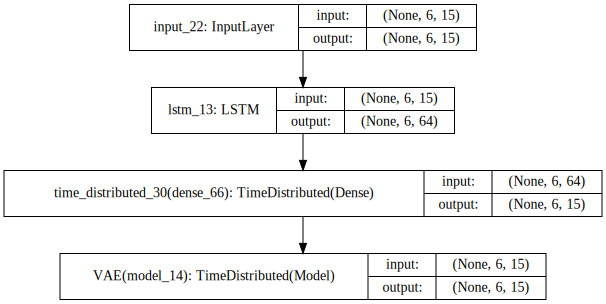

In [17]:
# Define VAE
original_dim = 15
hidden_dim = 64
intermediate_dim = 16
latent_dim = 2
window_size = 6
batch_size = 20
epsilon_std = 1.

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)

# Define LSTM
X = Input(shape=(window_size, original_dim))
h_lstm = LSTM(64, activation='relu', return_sequences=True)(X)
h_lstm_dense = TimeDistributed(Dense(original_dim, activation='elu'))(h_lstm)

outputs = TimeDistributed(vae, name='VAE')(h_lstm_dense)

varnn = Model(X, outputs)
varnn.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
print(varnn.summary())
SVG(model_to_dot(varnn, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [27]:
def split2sequences(data, length_x=1, length_y=1, split=0.8):
    print('Splitting text into sequences...', "\n",)
    step = 1
    xN = []
    yN = []
    
    for i in range(0, len(data) - length_x, step):
        xN.append(data[i: i + length_x])
        yN.append(data[i+1+length_x-length_y:i + length_x + 1])
        
    train_size = int(len(xN) * split)
    test_size = len(xN) - train_size
    
    xN = np.array(xN)
    yN = np.array(yN)
    n = len(data)
    X_train, X_test = xN[0:train_size],  xN[train_size:n]
    Y_train,Y_test = yN[0:train_size], yN[train_size:n]

    return xN, yN, X_train, X_test, Y_train, Y_test

In [42]:
def make_clean_data(window_size,batch_size, val_size=0.2,multiplier=300, process = False, time_percentage=0.9, explained_variance=0.9):
    filename = 'data.pickle'
    delete_other_idle = False
    if (process):
        df = pd.read_csv('data/rescuetime_data_category_2017-07-21.csv')
        data = Clean_DF(df)
        data.clean_data(time_percentage=time_percentage)
        data.clean_df = data.clean_df.reset_index()
        data.get_pca(explained_variance=explained_variance)
        data.get_day_time()

        with open(filename, 'wb') as f:  # Python 3: open(..., 'wb')
            pickle.dump(data, f)
    else:
        with open(filename, 'rb') as f:  # Python 3: open(..., 'rb')
            data = pickle.load(f)

    dataset = data.activity_vector
    popular_apps = data.popular_apps


    if (delete_other_idle):
    # Remove IDLE and OTHER time
        dataset = np.delete(dataset, [dataset.shape[1]-1,dataset.shape[1]-2], axis=1)
        del popular_apps[-1]
        del popular_apps[-1]



#     weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday']


#     days = set(data.clean_df['Day'])
#     df = data.clean_df[['Date', 'Activity Vector']]
#     df['timestamp'] = pd.to_datetime(df['Date'])
#     # print(df.dtypes)
#     df = df.set_index('timestamp').resample('300S').asfreq()
#     x = {'val': np.zeros(15)}
#     df['Activity Vector'] = df['Activity Vector'].fillna(x)
#     del df['Date']
#     df['Activity Vector'] = df['Activity Vector'].map(lambda x: np.zeros(len(popular_apps)) if np.isnan(np.sum(x)) else x)
#     df = df.reset_index()
#     dataset = df['Activity Vector']
#     dataset = np.asarray(dataset.tolist())

#     day_categorical = np.asarray(df.timestamp.dt.weekday)
#     time_categorical = np.asarray(df.timestamp.dt.time.map(lambda x: int(str(x)[0:2])))

    (Xc, yc, X_train_c, X_test_c, y_train_c, y_test_c)= split2sequences(dataset*multiplier, length_x=window_size, length_y=window_size, split=0.8)
#     (Xd, yd, X_train_d, X_test_d, y_train_d, y_test_d)= split2sequences(day_categorical, length_x=window_size, length_y=window_size, split=0.8)
#     (Xt, yt, X_train_t, X_test_t, y_train_t, y_test_t)= split2sequences(day_categorical, length_x=window_size, length_y=window_size, split=0.8)

#     indices = ~np.all(yc == 0, axis=1)
#     print(Xc.shape)
#     print(yc.shape)
#     print(len(indices))
#     Xc = Xc[indices, :, :]
#     yc = yc[indices, :]
    
#     Xd = Xd[indices,:]
#     yd = yd[indices]
    
#     Xt = Xt[indices,:]
#     yt = yt[indices]
    
    
    test_size = int(val_size * Xc.shape[0])           # In real life you'd want to use 0.2 - 0.5
    x_train_c, x_test_c, y_train_c, y_test_c = Xc[:-test_size], Xc[-test_size:], yc[:-test_size], yc[-test_size:]
#     Xt = Xt.reshape(Xt.shape[0],Xt.shape[1])
#     Xd = Xd.reshape(Xt.shape[0],Xt.shape[1])
#     x_train_t, x_test_t = Xt[:-test_size], Xt[-test_size:]
#     x_train_d, x_test_d = Xd[:-test_size], Xd[-test_size:]
    
    l_total = int(len(Xc)/batch_size)*batch_size
    l_train = int(len(x_train_c)/batch_size)*batch_size
    l_test = int(len(x_test_c)/batch_size)*batch_size
    
    Xc = Xc[:l_total]
    yc = yc[:l_total]
    x_train_c = x_train_c[:l_train]
    x_test_c = x_test_c[:l_test]
    y_train_c = y_train_c[:l_train]
    y_test_c = y_test_c[:l_test]
    
#     x_train_t = x_train_t[:l_train]
#     x_test_t = x_test_t[:l_test]

#     x_train_d = x_train_d[:l_train]
#     x_test_d = x_test_d[:l_test]
    
    y_train_labels = [dict(zip(popular_apps, np.round(300*x))) for x in y_train_c]
    y_test_labels = [dict(zip(popular_apps, np.round(300*x))) for x in y_test_c]
    y_labels = [dict(zip(popular_apps, np.round(300*x))) for x in yc]

    
#     cmap = {
#         'Instant Message' : (255,255,0),
#         'Video' : (255,0,0),
#         'General Software Development' : (255,0,200),
#         'General Social Networking' : (255,127,0),
#         'Writing' : (200,0,255),
#         'Browsers' : (0,255,200),
#         'General Reference & Learning' : (127,0,255),
#         'Email' : (127,255,0),
#         'Search' : (0,255,127),
#         'Uncategorized' : (128,128,128),
#         'General News & Opinion' : (0,200,255),
#         'Engineering & Technology' : (0,127,255),
#         'General Business' : (0,0,255),
#         'Voice Chat' : (200,255,0),
#         'other' : (200,200,200)
#     }
#     cmap = np.array([[255,255,0], [255,0,0], [255,0,200], 
#                      [255,127,0], [200,0,255], [0,255,200], 
#                      [127,0,255], [127,255,0], [0,255,127],
#                      [128,128,128],[0,200,255], [0,127,255], 
#                      [0,0,255], [200,255,0],  [200,200,200]])
#     yc_colors = convert_to_rgb(np.einsum('ij,jk->ik', data_['yc'], cmap))
#     y_train_c_colors = convert_to_rgb(np.einsum('ij,jk->ik', data_['y_train_c'], cmap))
#     y_test_c_colors = convert_to_rgb(np.einsum('ij,jk->ik', data_['y_test_c'], cmap))
#     data_colors = convert_to_rgb(cmap)
    
    data_ = {
        'Xc' : Xc,
        'yc' : yc,
        'x_train_c' : x_train_c,
        'x_test_c' : x_test_c,
        'y_train_c' : y_train_c,
        'y_test_c' : y_test_c,
#         'x_train_t' : x_train_t,
#         'x_test_t' : x_test_t,
#         'x_train_d' : x_train_d,
#         'x_test_d' : x_test_d,
        'popular_apps' : popular_apps,
#         'days' : len(set(day_categorical)),
#         'time' : len(set(time_categorical)),
#         'day_categorical' : day_categorical,
#         'time_categorical' : time_categorical,
        'dataset' : dataset,
#         'y_train_labels' : y_train_labels,
#         'y_test_labels' : y_test_labels,
#         'y_labels' : y_labels,
#         'yc_colors' : yc_colors,
#         'y_train_c_colors' : y_train_c_colors,
#         'y_test_c_colors' : y_test_c_colors,
#         'data_colors' : data_colors
    }
    return data_

In [43]:
data_ = make_clean_data(window_size=6,batch_size=20, val_size=0.2,multiplier=300, process = False, time_percentage=0.9, explained_variance=0.9)

Splitting text into sequences... 



In [45]:
print(data_['x_train_c'].shape)
print(data_['y_train_c'].shape)

(14620, 6, 15)
(14620, 6, 15)
